# Prévisions météorologiques en Australie

# Modélisation avec étape de ré-échantillonage

# Récupération des librairies

In [1]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [2]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time, datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree

from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

# Modèle de classification par apprentissage supervisé

### Préparation du jeu de données et paramètrage

In [3]:
# récuperation et aperçu du jeu de données après prétraitement, après l'étape de classification des villes en fonction 
# du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [4]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [5]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement 
# à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [6]:
# undersampling des données
rUs = RandomUnderSampler()
X_train, y_train = rUs.fit_resample(X_train, y_train)

In [7]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible ré-échantillonnée:", dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible ré-échantillonnée: {0: 25005, 1: 25005}


In [8]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [9]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 21962, 1: 6196}


In [10]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [11]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Arbres de décision

In [12]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

In [13]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.0,0.9,50)

In [14]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_dt = {'criterion':['gini'], 'max_depth':[8], 'class_weight': [{0:x, 1:1.0-x} for x in weights]}

In [15]:
# définition de la grille de recherche et d'une stratégie basée sur le F1-score pour rechercher le meilleur estimateur
gcv_dt1 = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring='f1_macro', n_jobs=-1, cv=3)

# entraînement du modèle
gcv_dt1.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.018367346938775512,
                                           1: 0.9816326530612245},
                                          {0: 0.036734693877551024,
                                           1: 0.963265306122449},
                                          {0: 0.05510204081632654,
                                           1: 0.9448979591836735},
                                          {0: 0.07346938775510205,
                                           1: 0.926530612244898},
                                          {0: 0.09183673469387756,
                                           1: 0.9081632653061225},
                                          {0: 0.110204081632653...
                                           1: 0.5775510204081633},
                                          {0: 0.4408163265306123,
                                           1: 0.5591836734693877},
                                          {0: 0.4591836734693878,
                                           1: 0.5408163265306122},
                                          {0: 0.47755102040816333,
                                           1: 0.5224489795918367},
                                          {0: 0.49591836734693884,
                                           1: 0.5040816326530612},
                                          {0: 0.5142857142857143,
                                           1: 0.48571428571428565},
                                          {0: 0.5326530612244899,
                                           1: 0.46734693877551015}, ...],
                         'criterion': ['gini'], 'max_depth': [8]},
             scoring='f1_macro')

In [16]:
# prédictions du modèle à l'aide d'un seuil de probabilités adapté pour mieux distinguer les classes
y_probas = gcv_dt1.predict_proba(X_test_scaled)
y_pred = (y_probas[:,1] >= 0.65).astype(bool)

# affichage des meilleurs paramètres
print('Meilleurs paramètres:', gcv_dt1.best_params_, "\n")

# vérification de l'underfitting et overfitting
print('Train Data Score: {}'.format(gcv_dt1.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_dt1.score(X_test_scaled, y_test)))

# affichage du rapport de classification 
print('\n', classification_report(y_test, y_pred))

# affichage du rapport de classification spécifique aux jeux de données déséquilibrés
print('\n', classification_report_imbalanced(y_test, y_pred))

Meilleurs paramètres: {'class_weight': {0: 0.5142857142857143, 1: 0.48571428571428565}, 'criterion': 'gini', 'max_depth': 8} 

Train Data Score: 0.7857424668627297
Test Data Score: 0.7145686610787618

               precision    recall  f1-score   support

           0       0.89      0.89      0.89     21962
           1       0.60      0.61      0.61      6196

    accuracy                           0.83     28158
   macro avg       0.75      0.75      0.75     28158
weighted avg       0.83      0.83      0.83     28158


                    pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.89      0.61      0.89      0.74      0.56     21962
          1       0.60      0.61      0.89      0.61      0.74      0.53      6196

avg / total       0.83      0.83      0.67      0.83      0.74      0.55     28158



- la méthode de régression logistique **fait l'objet d'un léger sur-apprentissage** (score=F1_macro)

La classe positive est caractérisée par:
- une précision et un rappel parfaitement équilibrés
- `un F1-score macro égal à 0.75`
- `une moyenne géométrique égale à 0.74`

### Interprétation du modèle

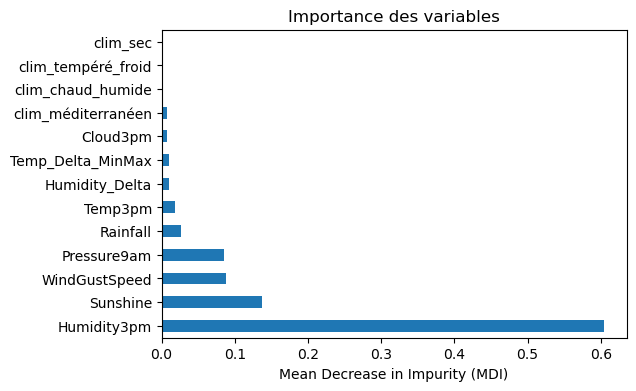

In [17]:
# affichage de l'importance des variables dans le jeu de données
fig = plt.figure(figsize=(6,4))
feature_imp = pd.Series(gcv_dt1.best_estimator_.feature_importances_, index=data.columns)
feature_imp.nlargest(13).plot(kind='barh')
plt.title("Importance des variables")
plt.xlabel("Mean Decrease in Impurity (MDI)");

Il apparaît clairement que la variable **"Humidity3pm"** est la plus importante dans ce modèle pour ce jeu de données. 

Les arbres de décision sont des méthodes d’apprentissage utilisées pour des problèmes de classification et de régression. 

L'idée c'est de modéliser la solution du problème de machine learning que l'on traite comme une suite de décision à prendre. 

L’objectif est de créer un modèle qui prédit les valeurs de la variable cible, en se basant sur un ensemble de séquences de règles de décision déduites à partir des données d’apprentissage. L’arbre de décision modélise la solution du problème comme une suite de décisions à prendre, par une succession de règles *if-then-else*. 

Les arbres de décision présentent plusieurs avantages qui les rendent intéressants dans des contextes où il est utile de comprendre la séquence de décisions prise par le modèle:
- ils sont considérés comme des modèles *white box*: le résultat est facile à interpréter et à visualiser,
- ils nécessitent peu de préparation des données,
- ils présent un coût d’utilisation logarithmique,
- ils sont capables d’utiliser des données catégorielles et numériques,
- ils sont capables de traiter des problèmes multi-classe.

Ces modèles présentent néanmoins deux inconvénients majeurs:
- sur-apprentissage: les arbres générés sont parfois trop complexes et généralisent mal. Choisir des bonnes valeurs pour les paramètres *max_depth* et *min_samples_leaf* permet d’éviter ce problème.
- déséquilibrage: les arbres générés sont parfois déséquilibrés (ce qui implique que le temps de parcours n’est plus logarithmique). Ajuster la base de données avant la construction, pour éviter qu’une classe domine largement les autres permet d'éviter ce problème.

Nous pouvons visualiser l'arbre de décision en utilisant la méthode *plot_tree()*. Le graphique d'un arbre de décision  devient vite illisible avec un paramètre *max-depth* supérieur à 3. Nous allons ici limiter la profondeur maximale de l'arbre de décision afin de simplifier la lisibilité et l'interprétation du modèle. Un nouvel entraînement du modèle est réalisé avec l'argument *max_depth=3*, ce qui permet de générer moins de noeuds et ainsi d'obtenir plus d'informations dans les feuilles.

In [18]:
# définition du modèle
clf_dt = DecisionTreeClassifier()

In [19]:
# définition de l'intervalle pour le coefficient de pondération
weights = np.linspace(0.0,0.9,50)

In [20]:
# définition de la grille de paramètres pour GridSearchCV
param_grid_dt = {'criterion':['gini'], 'max_depth':[3], 'class_weight': [{0:x, 1:1.0-x} for x in weights]}

In [21]:
# nouvel entraînement du modèle avec l'argument "max-depth=3" pour spécifier un seuil sur la profondeur maximale 
# de l’arbre et ainsi éviter de générer un arbre trop complexe, dur à visualiser
gcv_dt2 = GridSearchCV(clf_dt, param_grid=param_grid_dt, scoring='f1_macro', n_jobs=-1, cv=3)

# entraînement du modèle
gcv_dt2.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.018367346938775512,
                                           1: 0.9816326530612245},
                                          {0: 0.036734693877551024,
                                           1: 0.963265306122449},
                                          {0: 0.05510204081632654,
                                           1: 0.9448979591836735},
                                          {0: 0.07346938775510205,
                                           1: 0.926530612244898},
                                          {0: 0.09183673469387756,
                                           1: 0.9081632653061225},
                                          {0: 0.110204081632653...
                                           1: 0.5775510204081633},
                                          {0: 0.4408163265306123,
                                           1: 0.5591836734693877},
                                          {0: 0.4591836734693878,
                                           1: 0.5408163265306122},
                                          {0: 0.47755102040816333,
                                           1: 0.5224489795918367},
                                          {0: 0.49591836734693884,
                                           1: 0.5040816326530612},
                                          {0: 0.5142857142857143,
                                           1: 0.48571428571428565},
                                          {0: 0.5326530612244899,
                                           1: 0.46734693877551015}, ...],
                         'criterion': ['gini'], 'max_depth': [3]},
             scoring='f1_macro')

In [22]:
# conversion de l'ensemble d'entraînement standardisé en DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

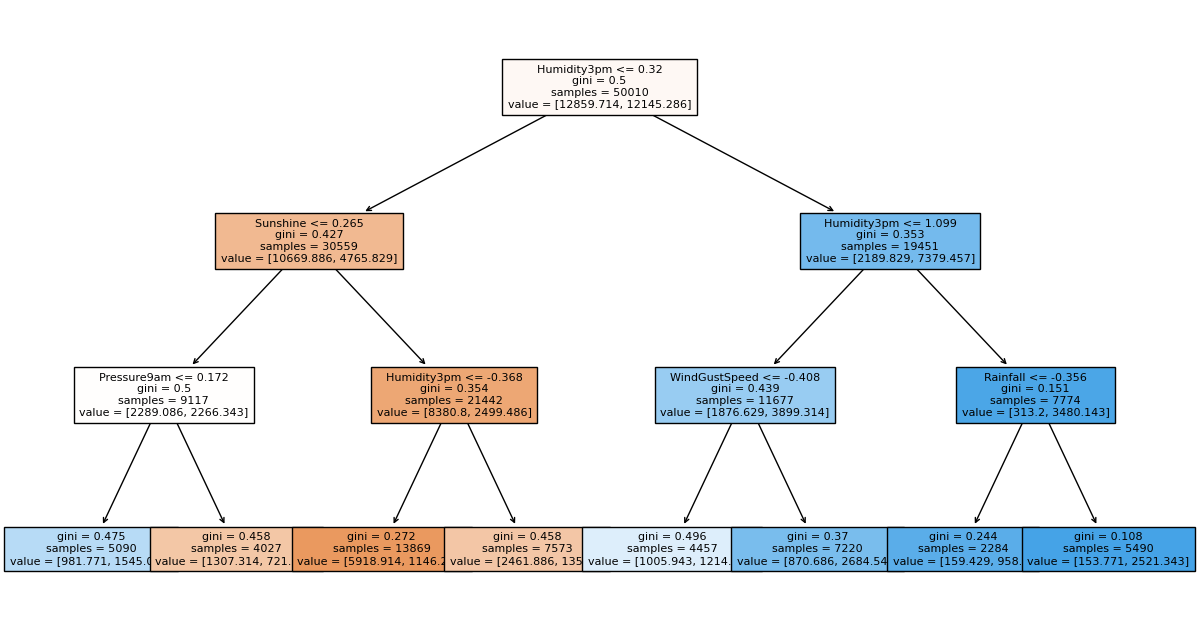

In [23]:
# représentation graphique de l'arbre de décision
plt.figure(figsize=(15,8))
plot_tree(gcv_dt2.best_estimator_, feature_names=X_train_scaled.columns.tolist(), filled=True, fontsize=8);

L'indice de diversité de **"Gini"** mesure la probabilité que l'arbre se trompe lors de la prise d'une décision. Il est compris entre 0 et 1 et atteint sa valeur minimale lorsque tous les éléments de l'ensemble sont dans une même classe de la variable-cible. 

Une autre alternative pour expliquer toutes les étapes dans un arbre de décision consiste à présenter le modèle comme du code parcourant de manière récursive les noeuds de l'arbre et affichant les règles de décision.

In [24]:
# définition de la fonction "tree_to_code()" permettant de générer une fonction Python "predict()" capable d'expliquer 
# les étapes de l'arbre de décision de manière algorithmique 
def tree_to_code(tree, feature_names):
    """
    Visualise un arbre de décision comme du code
    
    Paramètres:
    -----------
    tree: Modèle d'arbre de décision
    feature_names: liste des variables explicatives du modèle
    """

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def predict({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

Le code *predict()* ci-dessous a été généré à partir de la fonction *tree_to_code()*. Il est ainsi très facile d'adapter cette fonction pour produire des règles de décision adaptées à n'importe quel language de programmation.

In [25]:
# création d'une fonction Python appliquant les règles de décision du modèle avec une profondeur de l'arbre spécifiée
tree_to_code(gcv_dt2.best_estimator_, feature_names=X_train_scaled.columns.tolist())

def predict(Rainfall, Sunshine, WindGustSpeed, Humidity3pm, Pressure9am, Cloud3pm, Temp3pm, Temp_Delta_MinMax, Humidity_Delta, clim_chaud_humide, clim_méditerranéen, clim_sec, clim_tempéré_froid):
  if Humidity3pm <= 0.3196125626564026:
    if Sunshine <= 0.26486024260520935:
      if Pressure9am <= 0.17165830731391907:
        return [[ 981.77142857 1545.05714286]]
      else:  # if Pressure9am > 0.17165830731391907
        return [[1307.31428571  721.28571429]]
    else:  # if Sunshine > 0.26486024260520935
      if Humidity3pm <= -0.3682345449924469:
        return [[5918.91428571 1146.28571429]]
      else:  # if Humidity3pm > -0.3682345449924469
        return [[2461.88571429 1353.2       ]]
  else:  # if Humidity3pm > 0.3196125626564026
    if Humidity3pm <= 1.099172592163086:
      if WindGustSpeed <= -0.40844520926475525:
        return [[1005.94285714 1214.77142857]]
      else:  # if WindGustSpeed > -0.40844520926475525
        return [[ 870.68571429 2684.54285714]]
    else:

Le code Python généré pour l'arbre de décision sans réduire le paramètre *max_depth* apparait bien plus long et semble plus complexe (cf. ci-dessous), toutefois les règles de décisions restent faciles à suivre.

De cette manière, seulement quelques valeurs connues en entrée suffisent à l'utilisateur pour en déduire la probabilité des classes de la variable cible en sortie.

In [26]:
# création d'une fonction Python appliquant les règles de décision du modèle avec une profondeur de l'arbre non spécifiée
tree_to_code(gcv_dt1.best_estimator_, feature_names=X_train_scaled.columns.tolist())

def predict(Rainfall, Sunshine, WindGustSpeed, Humidity3pm, Pressure9am, Cloud3pm, Temp3pm, Temp_Delta_MinMax, Humidity_Delta, clim_chaud_humide, clim_méditerranéen, clim_sec, clim_tempéré_froid):
  if Humidity3pm <= 0.3196125626564026:
    if Sunshine <= 0.26486024260520935:
      if Pressure9am <= 0.17165830731391907:
        if WindGustSpeed <= 0.9744130373001099:
          if Humidity3pm <= -1.0102252066135406:
            if Humidity_Delta <= -2.587675929069519:
              if Pressure9am <= -0.1402326375246048:
                if Temp_Delta_MinMax <= 0.28873229771852493:
                  return [[ 0.51428571 13.6       ]]
                else:  # if Temp_Delta_MinMax > 0.28873229771852493
                  return [[3.08571429 2.42857143]]
              else:  # if Pressure9am > -0.1402326375246048
                if clim_tempéré_froid <= 0.55726358294487:
                  return [[4.11428571 0.        ]]
                else:  # if clim_tempéré_froid > 0.55726358294487
      